<a href="https://www.kaggle.com/code/yaramahrous/cnn-pretrained-models?scriptVersionId=199755619" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io as io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,Input
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import EfficientNetB3

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns",None)
pd.set_option('display.max_rows',None)

In [3]:
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"
labels_file = "/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt"

with open(labels_file, 'r') as f:
    animal_names = f.read().split('\n')

In [4]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

In [5]:
data = []
labels = []

for animal in animal_names:
    animal_dir = os.path.join(dataset_path, animal)
    for img_name in os.listdir(animal_dir):
        img_path = os.path.join(animal_dir, img_name)
        data.append(preprocess_image(img_path))
        labels.append(animal)

data = np.array(data)
labels = np.array(labels)

In [6]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [8]:
x_train.shape

(3888, 224, 224, 3)

In [9]:
x_val.shape

(432, 224, 224, 3)

In [10]:
x_test.shape

(1080, 224, 224, 3)

In [11]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
base_vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
base_vgg.trainable = False
base_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
model_vgg = Sequential([
    base_vgg,
    GlobalAveragePooling2D(),
    Dense(32, activation='elu'),
    Dense(len(animal_names), activation='softmax')
])


In [14]:
model_vgg.compile(optimizer=Adam(learning_rate=0.009),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [16]:
history = model_vgg.fit(datagen.flow(x_train,y_train), epochs=30, shuffle=True, verbose=2,validation_data=datagen.flow(x_val,y_val), batch_size=32 ,callbacks=[lr_scheduler])

Epoch 1/30



I0000 00:00:1727956244.850170      99 service.cc:145] XLA service 0x794a90006b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:

I0000 00:00:1727956244.850245      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5

I0000 00:00:1727956244.850252      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5

I0000 00:00:1727956258.039796      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 - 69s - 569ms/step - accuracy: 0.0849 - loss: 4.0754 - val_accuracy: 0.1806 - val_loss: 3.5241 - learning_rate: 0.0090

Epoch 2/30

122/122 - 46s - 377ms/step - accuracy: 0.2274 - loss: 3.0899 - val_accuracy: 0.2731 - val_loss: 2.9776 - learning_rate: 0.0090

Epoch 3/30

122/122 - 45s - 370ms/step - accuracy: 0.3169 - loss: 2.5999 - val_accuracy: 0.3079 - val_loss: 2.6894 - learning_rate: 0.0090

Epoch 4/30

122/122 - 45s - 369ms/step - accuracy: 0.4105 - loss: 2.2775 - val_accuracy: 0.3403 - val_loss: 2.5678 - learning_rate: 0.0090

Epoch 5/30

122/122 - 45s - 372ms/step - accuracy: 0.4537 - loss: 2.0768 - val_accuracy: 0.4005 - val_loss: 2.3922 - learning_rate: 0.0090

Epoch 6/30

122/122 - 46s - 375ms/step - accuracy: 0.4769 - loss: 1.9469 - val_accuracy: 0.4468 - val_loss: 2.2237 - learning_rate: 0.0090

Epoch 7/30

122/122 - 45s - 371ms/step - accuracy: 0.4954 - loss: 1.8470 - val_accuracy: 0.3750 - val_loss: 2.5067 - learning_rate: 0.0090

Epoch 8/30

122/122 - 45s - 366m

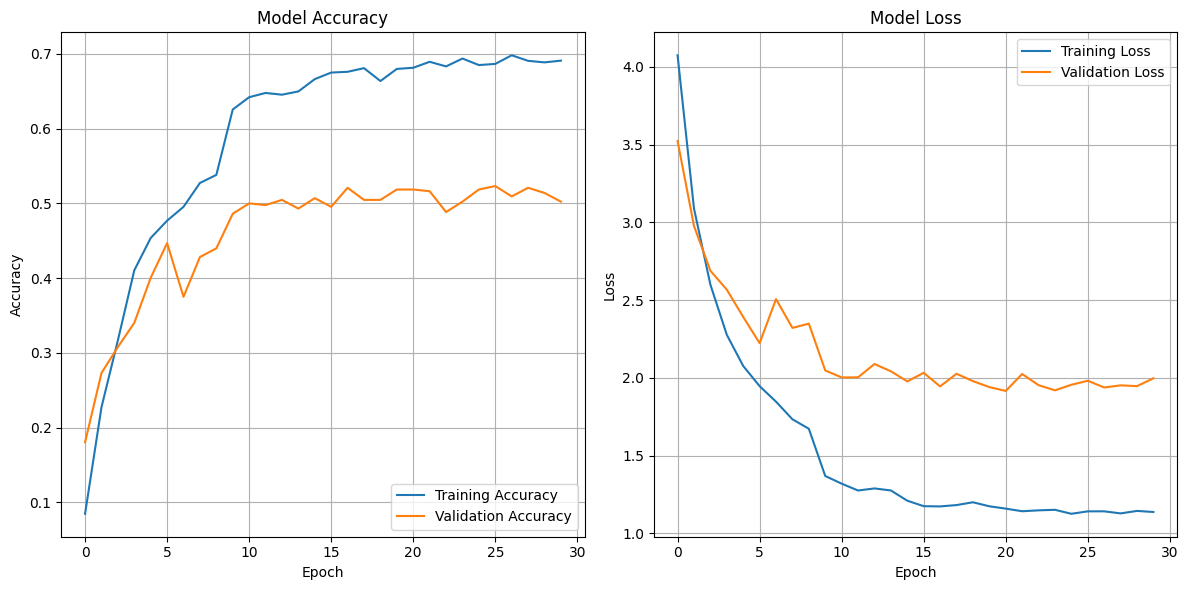

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [18]:
y_pred = model_vgg.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 437ms/step

                precision    recall  f1-score   support



      antelope       0.31      0.45      0.37        11

        badger       0.56      0.26      0.36        19

           bat       0.44      0.73      0.55        11

          bear       0.25      0.31      0.28        13

           bee       0.81      0.81      0.81        16

        beetle       0.44      0.73      0.55        11

         bison       0.55      0.50      0.52        12

          boar       0.36      0.25      0.30        16

     butterfly       0.69      0.75      0.72        12

           cat       0.89      0.62      0.73        13

   caterpillar       0.78      0.64      0.70        11

    chimpanzee       0.53      0.67      0.59        12

     cockroach       0.67      0.67      0.67        15

           cow       0.48      0.67      0.56        15

        coyote       0.38      0.27      0.32        11

          crab       0.73      0.80      0.

In [19]:
# cm = confusion_matrix(y_test, y_pred_classes)

# plt.figure(figsize=(20, 20))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=label_encoder.classes_, 
#             yticklabels=label_encoder.classes_)
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.title('Confusion Matrix')
# plt.show()

RESNET TIME

In [19]:
base_resnet = ResNet50(include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable=False
base_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
model_resnet = Sequential([
    base_resnet,
    GlobalAveragePooling2D(),
    Dense(32, activation='elu'),
    Dense(len(animal_names), activation='softmax')
])

In [21]:
model_resnet.compile(optimizer=Adam(learning_rate=0.009), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history2 = model_resnet.fit(datagen.flow(x_train,y_train), epochs=30, shuffle=True, verbose=2,validation_data=datagen.flow(x_val,y_val), batch_size=32 ,callbacks=[lr_scheduler])

Epoch 1/30

122/122 - 67s - 549ms/step - accuracy: 0.0123 - loss: 4.6498 - val_accuracy: 0.0023 - val_loss: 4.5936 - learning_rate: 0.0090

Epoch 2/30

122/122 - 45s - 372ms/step - accuracy: 0.0131 - loss: 4.5486 - val_accuracy: 0.0208 - val_loss: 4.4756 - learning_rate: 0.0090

Epoch 3/30

122/122 - 45s - 372ms/step - accuracy: 0.0159 - loss: 4.5244 - val_accuracy: 0.0579 - val_loss: 4.4035 - learning_rate: 0.0090

Epoch 4/30

122/122 - 45s - 367ms/step - accuracy: 0.0262 - loss: 4.4728 - val_accuracy: 0.0301 - val_loss: 4.3981 - learning_rate: 0.0090

Epoch 5/30

122/122 - 45s - 372ms/step - accuracy: 0.0219 - loss: 4.4495 - val_accuracy: 0.0185 - val_loss: 4.4460 - learning_rate: 0.0090

Epoch 6/30

122/122 - 46s - 375ms/step - accuracy: 0.0265 - loss: 4.4294 - val_accuracy: 0.0278 - val_loss: 4.4076 - learning_rate: 0.0090

Epoch 7/30

122/122 - 46s - 374ms/step - accuracy: 0.0231 - loss: 4.4174 - val_accuracy: 0.0394 - val_loss: 4.3956 - learning_rate: 0.0090

Epoch 8/30

122/122 

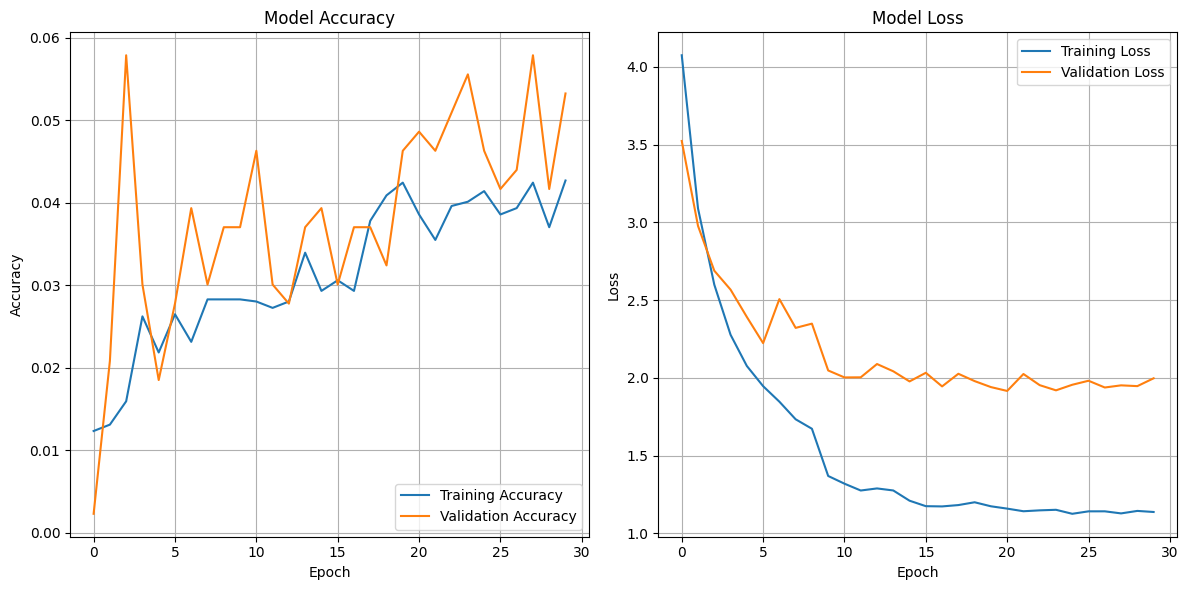

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history2.history['accuracy'], label='Training Accuracy')
ax1.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [24]:
y_pred = model_resnet.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step

                precision    recall  f1-score   support



      antelope       0.02      0.09      0.04        11

        badger       0.00      0.00      0.00        19

           bat       0.00      0.00      0.00        11

          bear       0.00      0.00      0.00        13

           bee       0.00      0.00      0.00        16

        beetle       0.00      0.00      0.00        11

         bison       0.00      0.00      0.00        12

          boar       0.00      0.00      0.00        16

     butterfly       0.12      0.25      0.16        12

           cat       0.00      0.00      0.00        13

   caterpillar       0.01      0.09      0.02        11

    chimpanzee       0.00      0.00      0.00        12

     cockroach       0.05      0.07      0.05        15

           cow       0.00      0.00      0.00        15

        coyote       0.05      0.18      0.08        11

          crab       0.00      0.00      0.

In [25]:
base_effnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_effnet.trainable = False


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model_effnet = Sequential([
    base_effnet,
    GlobalAveragePooling2D(),
    Dense(32, activation='elu'),
    Dense(len(animal_names), activation='softmax')
])

In [27]:
model_effnet.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model_effnet.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=30, 
                    validation_data=datagen.flow(x_val,y_val),
                    callbacks=[lr_scheduler])

Epoch 1/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 157s 776ms/step - accuracy: 0.0051 - loss: 4.5130 - val_accuracy: 0.0023 - val_loss: 4.5075 - learning_rate: 1.0000e-04

Epoch 2/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 354ms/step - accuracy: 0.0096 - loss: 4.5059 - val_accuracy: 0.0069 - val_loss: 4.5064 - learning_rate: 1.0000e-04

Epoch 3/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 45s 353ms/step - accuracy: 0.0099 - loss: 4.5036 - val_accuracy: 0.0139 - val_loss: 4.5077 - learning_rate: 1.0000e-04

Epoch 4/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 358ms/step - accuracy: 0.0160 - loss: 4.5027 - val_accuracy: 0.0069 - val_loss: 4.5081 - learning_rate: 1.0000e-04

Epoch 5/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.0099 - loss: 4.5029 - val_accuracy: 0.0116 - val_loss: 4.5055 - learning_rate: 1.0000e-04

Epoch 6/30

122/122 ━━━━━━━━━━━━━━━━━━━━ 46s 357ms/step - accuracy: 0.0070 - loss: 4.5018 - val_accuracy: 0.0139 - val_loss: 4.5090 - learning_rate: 1.0000e-04

Epoch 7/30

122/122 ━━━━━━━━━━━━━

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history3.history['accuracy'], label='Training Accuracy')
ax1.plot(history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model_effnet.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Fine Tunning

In [ ]:
for layer in base_vgg.layers[-10:]:
    layer.trainable = True

In [ ]:
model_vgg_fine = Sequential([
    base_vgg,
    GlobalAveragePooling2D(),
    Dense(32, activation='elu'),
    Dense(len(animal_names), activation='softmax')
])



In [ ]:
model_vgg_fine.compile(optimizer=Adam(learning_rate=0.009),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model_vgg_fine.fit(datagen.flow(x_train,y_train), epochs=30, shuffle=True, verbose=2,validation_data=datagen.flow(x_val,y_val), batch_size=32 ,callbacks=[lr_scheduler])